# Multi-Dimensional Scaling (MDS) example for cities

Author: Camilo Akimushkin Valencia

Inspired by https://baoilleach.blogspot.com/2014/01/convert-distance-matrix-to-2d.html

In [1]:
import numpy as np
import pandas as pd

from geopy.distance import geodesic
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt

from sklearn.manifold import MDS

In [2]:
# Cities from the state of São Paulo in Brazil
# population estimatives given by chatgpt based on IBGE 2020

city_pops = {
    "São Paulo": 12325232,
    "Guarulhos": 1393283,
    "Osasco": 699944,
    "Barueri": 274062,
    "Itapevi": 241971,
    "Francisco Morato": 177411,
    "Embu das Artes": 287513,
    "Santo André": 721368,
    "São Bernardo do Campo": 844483,
    "São Caetano do Sul": 162595,
    "Ferraz de Vasconcelos": 194262,
    "Itaquaquecetuba": 387078,
    "Jundiaí": 423006,
    "Mauá": 483294,
    "Suzano": 301349,
    "Santos": 433943,
    "Guarujá": 313851,
    "Praia Grande": 337542,
    "Taboão da Serra": 284049,
    "Itapecerica da Serra": 167778,
    "Mogi das Cruzes": 459579,
    "Diadema": 423909,
    "Bertioga": 58019,
    "Cotia": 249445,
    "Carapicuíba": 411607,
    "Franco da Rocha": 168719,
    "Santana de Parnaíba": 164208,
    "Jandira": 126846,
    "Cubatão": 128861,
}

In [3]:
city_pops = pd.DataFrame.from_dict(city_pops, orient='index', columns=['pop'])

In [4]:
city_pops["poplog"] = np.log10(city_pops["pop"] / 1000)
city_pops["pop_fontsize"] = (city_pops["poplog"]) * 9
city_pops["pop_markersize"] = (city_pops["pop"] ** 0.5) / 5

In [5]:
cities = list(city_pops.index)

## Get coordinates for cities

Of course, we will use these ONLY to get the distances

In [6]:
# Create a geocoder object
geolocator = Nominatim(user_agent="my-app")

In [7]:
def get_coords(city):
    location = geolocator.geocode(city)
    return (location.longitude, location.latitude)  # x, y

In [8]:
coords_original = pd.Series(index=cities, data=[get_coords(city) for city in cities])

In [9]:
coords_original_array = np.array([[coord[0], coord[1]] for coord in coords_original])

## Plot with original coordinates

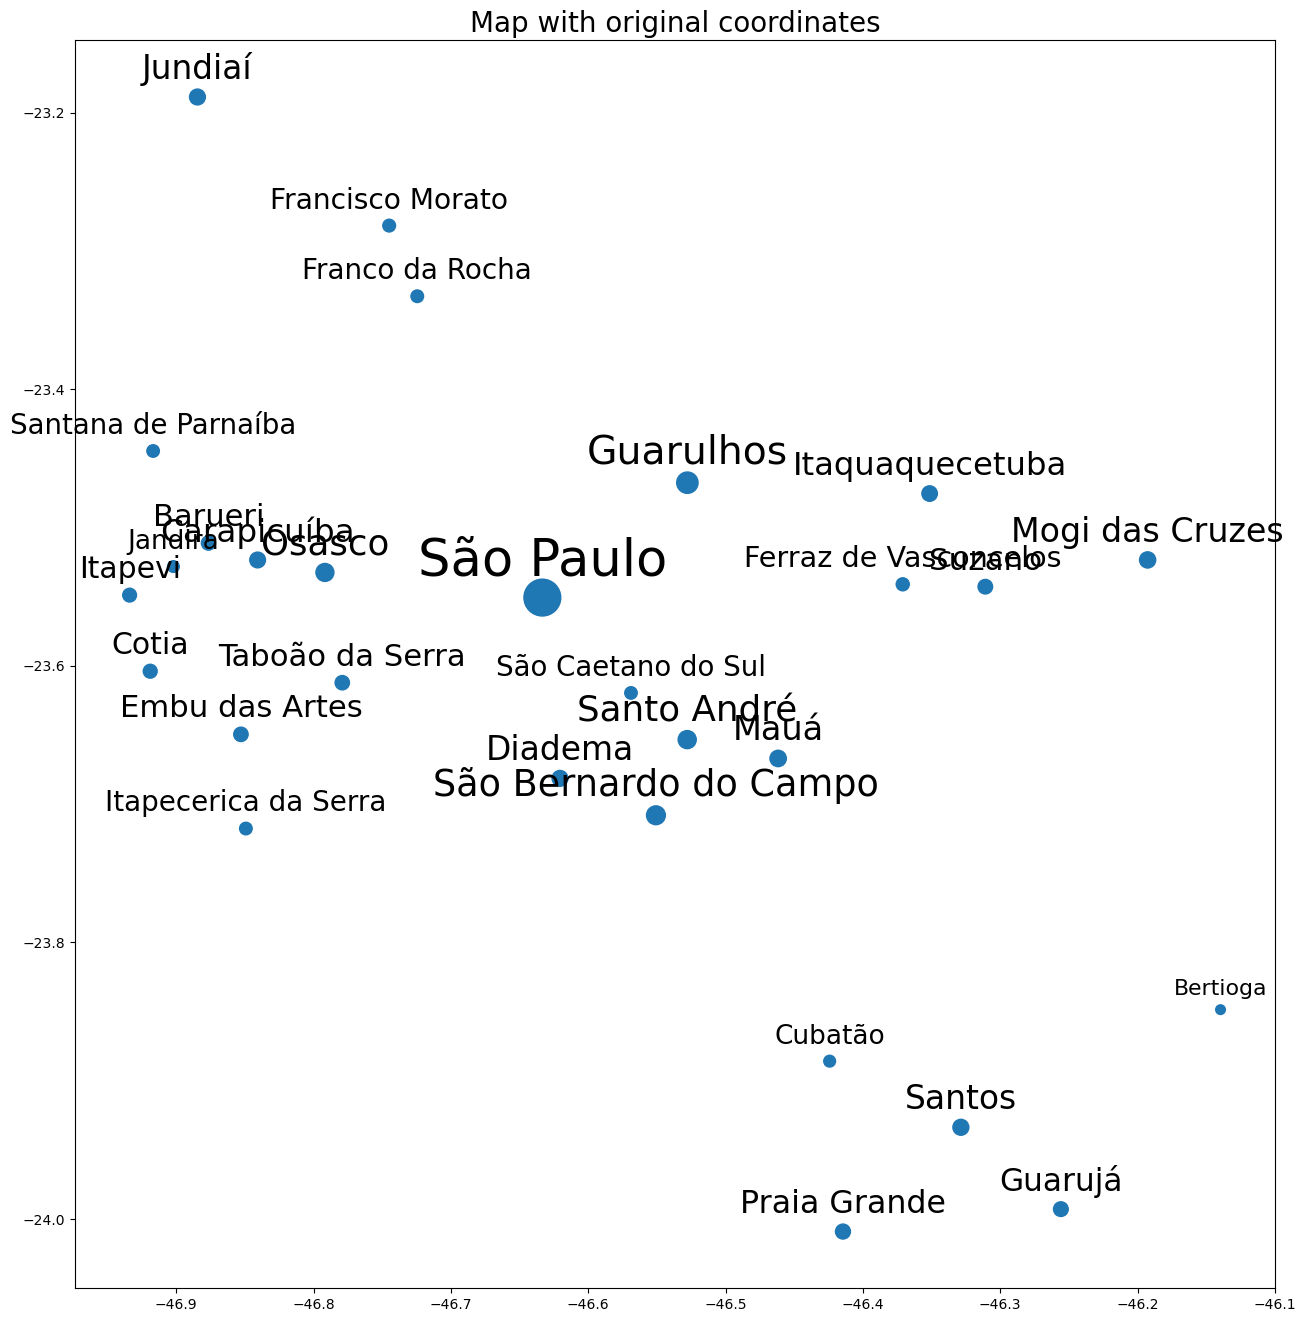

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 16))
plt.subplots_adjust(left=-0.1, bottom = 0.1)
plt.scatter(
    coords_original_array[:, 0], coords_original_array[:, 1],
    marker='o', s=city_pops["pop_markersize"]
    )
for label, x, y in zip(cities, coords_original_array[:, 0], coords_original_array[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(0, 8),
        fontsize=city_pops["pop_fontsize"][label],
        textcoords='offset points', ha='center', va='bottom'
    )

ax.set_title("Map with original coordinates", fontsize=20)
plt.show()

## Get distance matrix

In [11]:
distances = pd.DataFrame(index=cities, columns=cities)

In [12]:
for city1 in cities:
    for city2 in cities:
        distance = geodesic(coords_original[city1], coords_original[city2]).kilometers
        distances.loc[city1, city2] = distance

In [13]:
distances.head()

,São Paulo,Guarulhos,Osasco,Barueri,Itapevi,Francisco Morato,Embu das Artes,Santo André,São Bernardo do Campo,São Caetano do Sul,...,Itapecerica da Serra,Mogi das Cruzes,Diadema,Bertioga,Cotia,Carapicuíba,Franco da Rocha,Santana de Parnaíba,Jandira,Cubatão
São Paulo,0.0,13.355105,17.651929,27.189541,33.406577,24.017856,25.540628,14.121561,15.165507,8.910214,...,27.178432,49.03433,10.110821,59.481464,31.998141,23.137937,19.500851,32.526617,29.910654,34.668971
Guarulhos,13.355105,0.0,29.754753,38.905534,45.571949,28.020142,38.724553,14.250672,18.618455,12.519214,...,40.533114,37.496549,19.359738,52.176085,44.709899,35.046229,24.177666,43.279042,41.859159,34.118202
Osasco,17.651929,29.754753,0.0,9.563553,15.858448,19.847141,11.2254,30.746272,29.970316,25.653552,...,15.510064,66.590473,22.172423,76.444703,15.153705,5.490583,16.987971,15.434785,12.268666,49.005077
Barueri,27.189541,38.905534,9.563553,0.0,6.999404,22.818653,10.867664,40.242425,39.218285,35.186983,...,16.027187,76.017525,31.281128,85.906489,8.491935,4.085838,21.704391,6.767406,3.12127,57.878656
Itapevi,33.406577,45.571949,15.858448,6.999404,0.0,29.269535,11.83194,45.831925,44.30257,40.939976,...,15.935398,82.419049,36.275376,91.239696,4.509175,10.541294,28.52899,8.161639,3.878233,62.248838


In [14]:
dists = distances.to_numpy()

## Get MDS embedding

In [15]:
np.random.seed(42)

In [16]:
adist = np.array(dists)
amax = np.amax(adist)
adist /= amax

mds = MDS(
    n_components=2,
    dissimilarity="precomputed",
    random_state=42,
    eps=1e-8,
    normalized_stress="auto"
)
results = mds.fit(adist)

coords_mds = results.embedding_

## Plot Embedding

mirror horizontally

In [17]:
coords_mds[:,0] *= -1  # for this specific mapping

rotate counterclockwise

In [18]:
angle = 25  # for this specific mapping

In [19]:
angle_rad = np.radians(angle)
rotation_matrix = np.array([
    [np.cos(angle_rad), -np.sin(angle_rad)],
    [np.sin(angle_rad), np.cos(angle_rad)]]
)

In [20]:
coords_mds = np.dot(rotation_matrix, coords_mds.T).T

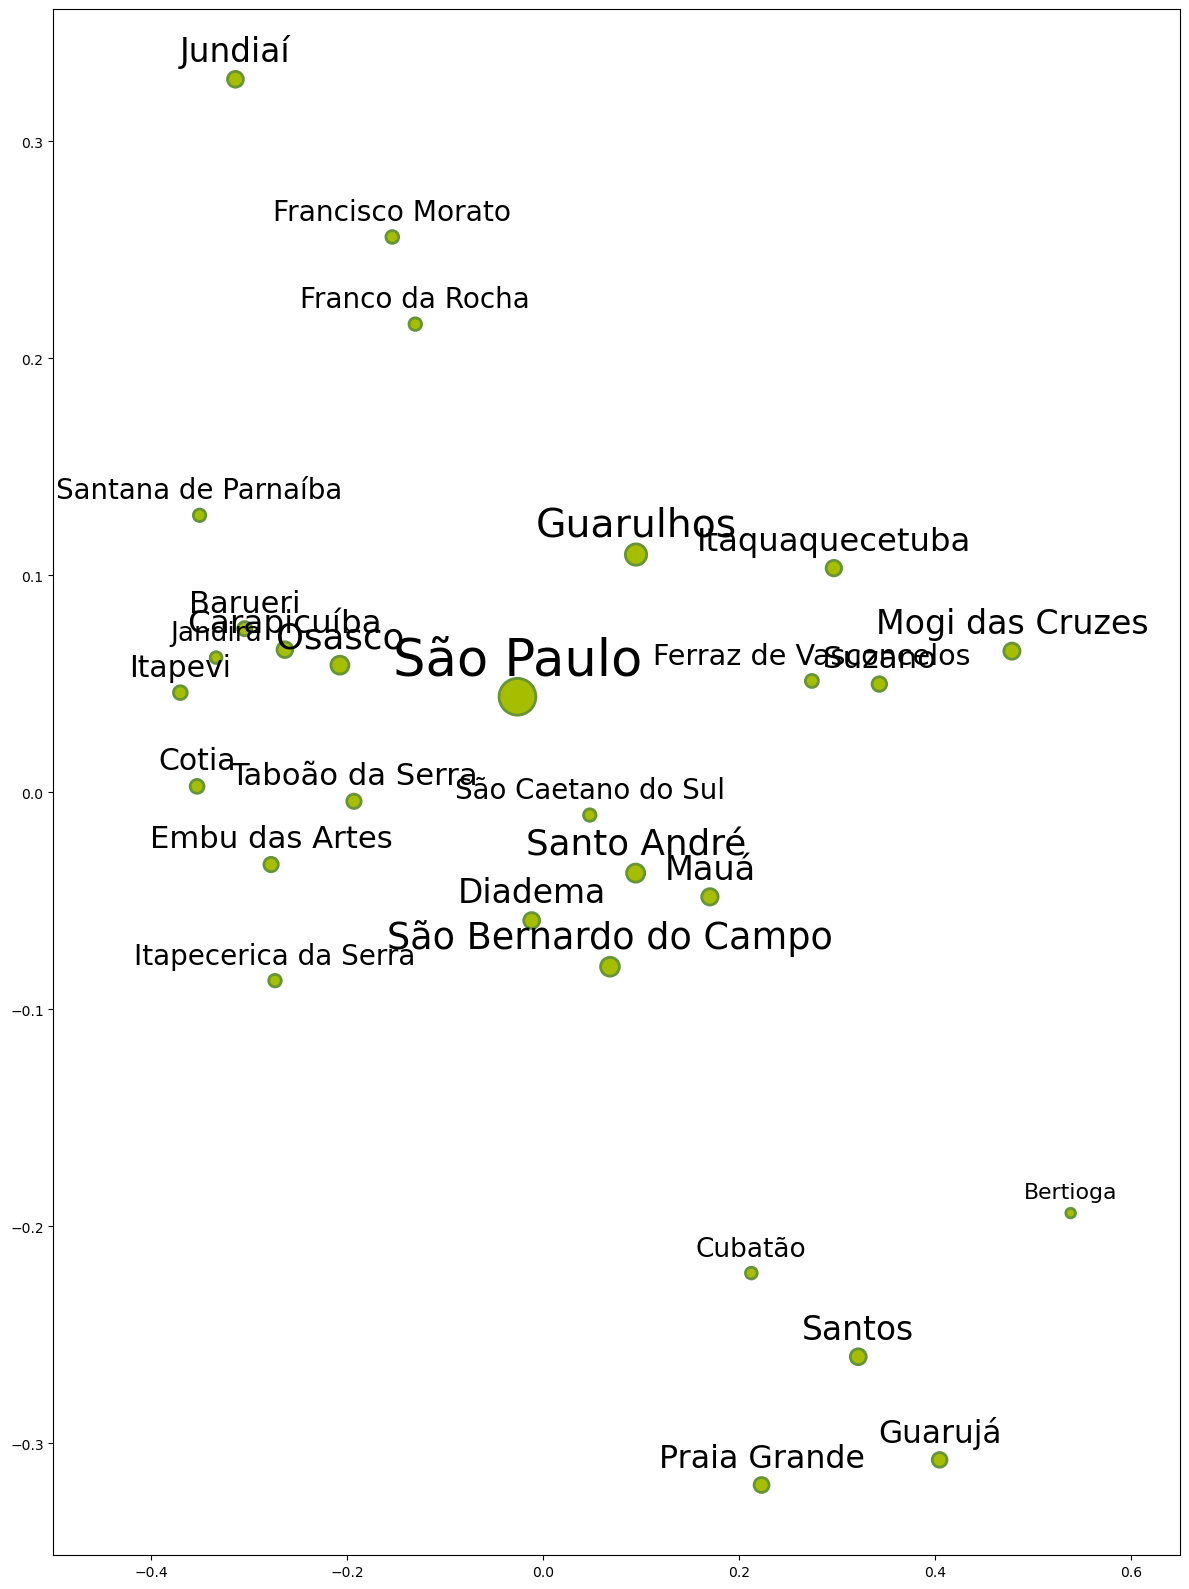

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 16))
plt.subplots_adjust(left=-0.1, bottom = 0.1)
plt.scatter(
    coords_mds[:, 0], coords_mds[:, 1],
    marker='o', s=city_pops["pop_markersize"],
    c="#a5be00", edgecolor="#679436", linewidths=2
    )
for label, x, y in zip(cities, coords_mds[:, 0], coords_mds[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(0, 8),
        fontsize=city_pops["pop_fontsize"][label],
        textcoords='offset points', ha='center', va='bottom'
    )

ax.set_xlim(-0.5, 0.65)
plt.tight_layout()
#plt.savefig("mds_cities.png", dpi=200)
plt.show()

## Elbow method to find the right dimensionality

In our example, the distance matrix is given by the geodesic distances among cities, so, apart from earth's curvature effects, we _know_ that a mapping to a bidimensional space will give the best results.

If we don't know the optimal space dimensionality we can use the _elbow method_ as a rule of thumb.

In [22]:
m = list(range(1, len(cities) + 1))
stress = []
for i in m:
    np.random.seed(42)
    mds = MDS(
        n_components=i,
        dissimilarity="precomputed",
        random_state=42,
        eps=1e-8,
        normalized_stress="auto"
    )
    results = mds.fit(adist)
    stress.append(results.stress_)

Text(0, 0.5, 'Stress')

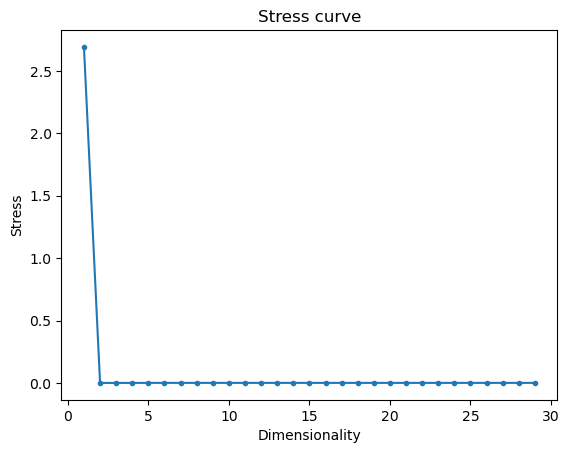

In [23]:
plt.plot(m, stress, '.-')
plt.title("Stress curve")
plt.xlabel("Dimensionality")
plt.ylabel("Stress")
#plt.savefig("stress_curve.png")

the elbow in m=2 is so sharp that we can't even tell the difference from higher values! let's zoom in:

Text(0, 0.5, 'Stress')

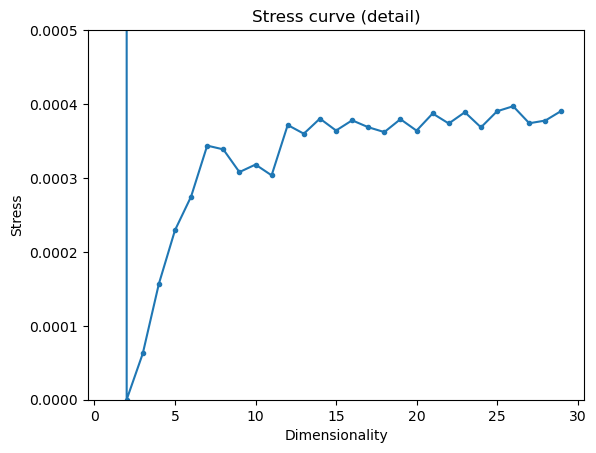

In [24]:
plt.plot(m, stress, '.-')
plt.ylim(0, 0.0005)
plt.title("Stress curve (detail)")
plt.xlabel("Dimensionality")
plt.ylabel("Stress")
#plt.savefig("stress_curve_detail.png")